# Outliers:
---

audio를 7초로 자르는 processing 진행하면서 찾아낸 이상치들

1. 호흡 시작이 7초 이후인 데이터
2. 호흡 주기가 7초 이상인 데이터

3. 마지막 호흡 이후 7초 이상 어노테이션이 없는 데이터
4. 7초 기준으로 데이터를 잘랐을 때 양 끝 1초 이하인 데이터 -> bbox의 width가 0이 되서 오류발생



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# import
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
database_dir = '/content/drive/MyDrive/data/ICBHI_final_database'

sample_rate = 8000
n_mels = 64
n_fft = 512
hop_length = n_fft // 2
fmax = 2500
duration = 7

### wav File 7초 * sr 로 샘플 나누기

In [10]:
def split_audio_file(file_path, duration, sr=8000):
    # 오디오 파일 로딩
    audio, sr = librosa.load(file_path, sr=sr)

    # 분할할 샘플의 수 계산
    samples_per_segment = int(duration * sr)

    # 총 세그먼트 수 계산
    total_segments = int(np.ceil(len(audio) / samples_per_segment))

    # 세그먼트별로 오디오 분할
    segments = []
    for segment in range(total_segments):
        start_sample = samples_per_segment * segment
        end_sample = start_sample + samples_per_segment
        segments.append(audio[start_sample:end_sample])

    return audio, segments

def zero_padd(segments, duration, sr=8000):
    segments_ls = []
    for segment in segments:
        padding_length = duration*sr - len(segment)
        if int(len(segment)/sr) < duration:
            padded_audio = np.pad(segment, (0, padding_length), mode='constant', constant_values=(0, 0))
        else:
            padded_audio = segment
        segments_ls.append(padded_audio)
    return segments_ls

In [14]:
filename = '175_1b1_Al_sc_Litt3200'
# 사용 예시: 'my_audio_file.wav'를 7초 단위로 분할
audio, segments = split_audio_file(os.path.join(database_dir, filename+'.wav'), duration=duration, sr=8000)
len(segments[0])
ls = zero_padd(segments, duration)
print(len(ls))
print(len(ls[0]))
print(len(ls[1]))
print(len(ls[2]))

3
56000
56000
56000


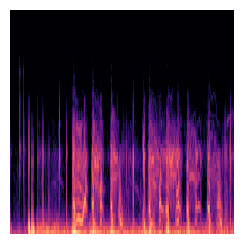

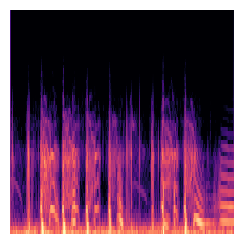

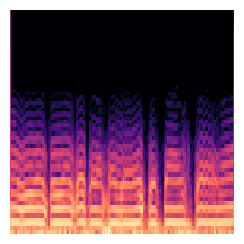

In [16]:
for y in segments:

    S = librosa.feature.melspectrogram(y=y,
                                        sr=sample_rate,
                                        n_fft=n_fft,
                                        hop_length=hop_length,
                                        n_mels=n_mels,
                                        fmax=fmax)
    # S_dB: array
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.24, 2.24))  # 이미지 크기를 인치 단위로 설정 (224x224 픽셀이 되도록 DPI 조정 필요)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ## show
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')

## 이상치 확인

### 1. 호흡 시작이 7초 이후인 데이터

In [18]:
all_files = os.listdir(database_dir)

txt_files = sorted([file for file in all_files if file.endswith('.txt')])
df_dict = {}
all_data = pd.DataFrame(columns=['filename', 'start', 'end', 'crackle', 'wheeze'])

for i, filename in enumerate(txt_files):
    file_path = os.path.join(database_dir, filename)

    annot = pd.read_csv(file_path, sep='\t', names=['start', 'end', 'crackle', 'wheeze'])
    annot = annot.head(1)
    annot['filename'] = filename

    # 읽은 데이터프레임을 전체 데이터프레임에 추가
    all_data = pd.concat([all_data, annot], ignore_index=True)

    if i % 100 ==0: print(i,'/920')
all_data

0 /920
100 /920
200 /920
300 /920
400 /920
500 /920
600 /920
700 /920
800 /920
900 /920


,filename,start,end,crackle,wheeze
0,101_1b1_Al_sc_Meditron.txt,0.036,0.5790,0,0
1,101_1b1_Pr_sc_Meditron.txt,0.036,1.2640,0,0
2,102_1b1_Ar_sc_Meditron.txt,0.264,1.7360,0,0
3,103_2b2_Ar_mc_LittC2SE.txt,0.364,3.2500,0,1
4,104_1b1_Al_sc_Litt3200.txt,0.000,1.8771,0,0
...,...,...,...,...,...
915,224_1b2_Al_sc_Meditron.txt,0.022,3.6070,0,0
916,225_1b1_Pl_sc_Meditron.txt,0.036,1.0500,0,0
917,226_1b1_Al_sc_Meditron.txt,0.022,0.9790,0,0
918,226_1b1_Ll_sc_Meditron.txt,0.107,2.2070,0,0


In [19]:
# 확인
for idx, row in all_data.iterrows():
    filename = row['filename']
    start = row['start']
    if int(start) >= 7:
        print(filename, '||', start)
    if idx % 100 ==0: print(idx,'/920')

0 /920
100 /920
200 /920
300 /920
157_1b1_Lr_sc_Meditron.txt || 31.77
400 /920
500 /920
600 /920
700 /920
800 /920
900 /920
222_1b1_Ar_sc_Meditron.txt || 7.8172


### 2. 호흡 주기가 7초 이상인 데이터

In [20]:
# df 초기화
all_data = pd.DataFrame(columns=['filename', 'start', 'end', 'crackle', 'wheeze'])

for i, filename in enumerate(txt_files):
    file_path = os.path.join(database_dir, filename)

    annot = pd.read_csv(file_path, sep='\t', names=['start', 'end', 'crackle', 'wheeze'])
    annot['filename'] = filename
    annot['end-start'] = annot['end'] - annot['start']

    # 읽은 데이터프레임을 전체 데이터프레임에 추가
    all_data = pd.concat([all_data, annot], ignore_index=True)

    if i % 100 ==0: print(i,'/920')
all_data

0 /920
100 /920
200 /920
300 /920
400 /920
500 /920
600 /920
700 /920
800 /920
900 /920


,filename,start,end,crackle,wheeze,end-start
0,101_1b1_Al_sc_Meditron.txt,0.036,0.579,0,0,0.543
1,101_1b1_Al_sc_Meditron.txt,0.579,2.450,0,0,1.871
2,101_1b1_Al_sc_Meditron.txt,2.450,3.893,0,0,1.443
3,101_1b1_Al_sc_Meditron.txt,3.893,5.793,0,0,1.900
4,101_1b1_Al_sc_Meditron.txt,5.793,7.521,0,0,1.728
...,...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE.txt,11.721,13.693,1,0,1.972
6894,226_1b1_Pl_sc_LittC2SE.txt,13.693,15.536,0,0,1.843
6895,226_1b1_Pl_sc_LittC2SE.txt,15.536,17.493,0,0,1.957
6896,226_1b1_Pl_sc_LittC2SE.txt,17.493,19.436,1,0,1.943


In [21]:
# 확인
for idx, row in all_data.iterrows():
    filename = row['filename']
    t = row['end-start']
    if t >= 7:
        print(filename, '||', t)
    if idx % 500 ==0: print(idx,'/6890')

0 /6890
110_1b1_Pr_sc_Meditron.txt || 7.4439999999999955
500 /6890
116_1b2_Pl_sc_Meditron.txt || 7.0569999999999995
1000 /6890
1500 /6890
2000 /6890
2500 /6890
3000 /6890
157_1b1_Al_sc_Meditron.txt || 7.155599999999999
157_1b1_Ar_sc_Meditron.txt || 7.785299999999999
157_1b1_Ar_sc_Meditron.txt || 9.915000000000003
157_1b1_Ar_sc_Meditron.txt || 11.204999999999998
162_1b2_Al_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Al_mc_AKGC417L.txt || 7.830000000000002
162_1b2_Ar_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Ar_mc_AKGC417L.txt || 7.830000000000002
162_1b2_Ll_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Ll_mc_AKGC417L.txt || 7.830000000000002
162_1b2_Lr_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Lr_mc_AKGC417L.txt || 7.830000000000002
162_1b2_Pl_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Pl_mc_AKGC417L.txt || 7.830000000000002
162_1b2_Pr_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Pr_mc_AKGC417L.txt || 7.830000000000002
162_1b2_Tc_mc_AKGC417L.txt || 7.311999999999999
162_1b2_Tc_m

### preprocessing 과정 중 1, 2, 3의 경우 처리

In [ ]:
def wav_annot_split(database_dir, filename, duration=7, sr=8000):

    wav_path = os.path.join(database_dir, filename + '.wav')
    txt_path = os.path.join(database_dir, filename + '.txt')

    # wav 데이터 얻어와서 잘라줌, 리스트로 반환 (위에서 정의한 함수 사용)
    segments = split_audio_file(wav_path, duration=duration, sr=sr)
    padded_segments = zero_padd(segments, duration=duration, sr=sr)

    # txt 데이터 가져옴
    annot_df = pd.read_csv(txt_path, sep='\t', names=['start', 'end', 'crackle', 'wheeze'])


    # AUDIO segment

    # segment보다 긴 경우 몫 구해주기 ##################################################### -> 1. 호흡 시작이 7초 이후인 데이터

    if annot_df['start'][0] >= duration:
        quotient = annot_df['start'][0] // duration
        # 몫으로 호흡주기 데이터 없는 부분 제외
        padded_segments = padded_segments[int(quotient):]
        # 전체 호흡 수 몫만큼 줄여주기
        annot_df['start'] = annot_df['start'] - quotient*duration
        annot_df['end'] = annot_df['end'] - quotient*duration
        # 뒷 부분의 segment에 annotation이 없는 경우 -> 이미지 제거 (3/31 추가) ############### -> 3. 마지막 호흡 이후 7초 이상 어노테이션이 없는 데이터
        y, _ = librosa.load(wav_path, sr=sr)
        divider = duration - quotient*duration
        if divider > 0:
            if ((len(y)/sr) - (annot_df['end'].iloc[-1])) // divider >= 1.0:
                quotient2 = ((len(y)/sr) - (annot_df['end'].iloc[-1]))//duration
                padded_segments = padded_segments[:-int(quotient2)]

    else:
        # 뒷 부분의 segment에 annotation이 없는 경우 -> 이미지 제거 (3/31 추가) ############### -> 3. 마지막 호흡 이후 7초 이상 어노테이션이 없는 데이터
        y, _ = librosa.load(wav_path, sr=sr)
        quotient = annot_df['start'][0] // duration
        divider = duration - quotient*duration
        if divider > 0:
            if ((len(y)/sr) - (annot_df['end'].iloc[-1])) // divider >= 1.0:
                quotient2 = ((len(y)/sr) - (annot_df['end'].iloc[-1]))//duration
                padded_segments = padded_segments[:-int(quotient2)]


    # ANNOTATION segment

    # duration(default=7) 기준으로 행 "추가"해서 df 다시만들기
    # 세그먼트 별 마지막 인덱스 추출 및 조정(split기준점)
    i_ls = [annot_df[annot_df['start'] < duration * (n + 1)].index.max() for n in range(len(padded_segments))]
    i_ls = [x + i for i, x in enumerate(i_ls) if pd.notnull(x)]  # NaN 값 제외하고 인덱스 조정

    # 7초 단위로 나눠지는 포인트 수
    split_point_num = int(annot_df['end'].iloc[-1] // duration) # 인덱스 넘어가는 부분 수정(03/31) ## -> 3. 마지막 호흡 이후 7초 이상 어노테이션이 없는 데이터
    # 애너테이션 데이터 수정
    for i, t in enumerate(i_ls):
        if i == split_point_num: break # 인덱스 넘어가는 부분 수정(03/31) ########################### -> 3. 마지막 호흡 이후 7초 이상 어노테이션이 없는 데이터

        end_duration = duration * (i+1)
        df1 = annot_df.iloc[:t]  # 첫 번째 부분
        df2 = annot_df.iloc[t + 1:]  # 두 번째 부분

        row_at_split = annot_df.iloc[t]
        time_offset = duration * (i + 1) ############################################### -> 2. 호흡 주기가 7초 이상인 데이터: 새로운 행 추가

        # 새로운 행 생성
        new_rows = pd.DataFrame({
            'start': [row_at_split['start'], time_offset],
            'end': [time_offset, row_at_split['end']],
            'crackle': [row_at_split['crackle']] * 2,
            'wheeze': [row_at_split['wheeze']] * 2
        })
        annot_df = pd.concat([df1, new_rows, df2]).reset_index(drop=True)


    # 각 segment에 대한 annotation df를 저장할 리스트
    adjusted_dfs = []

    # 맨 앞 [0]이랑 맨 뒤 [-1]부분 추가 -> zip(split_points[:-1], split_points[1:]) 이부분에서 사용됨
    split_points = [0] + [index + 1 for index in i_ls][:int(split_point_num)] + [len(annot_df)]

    for i, (start, end) in enumerate(zip(split_points[:-1], split_points[1:])):
        segment_df = annot_df.iloc[start:end].copy()  # 분할된 세그먼트 복사
        adjustment = i * duration  # 각 세그먼트마다 빼줄 값 계산

        # 'start'와 'end' 컬럼 조정
        segment_df['start'] = segment_df['start'] - adjustment
        segment_df['end'] = segment_df['end'] - adjustment
        # 'normal' 컬럼 추가: 'crackle'과 'wheeze'가 모두 0일 경우 1, 아니면 0
        segment_df['normal'] = segment_df.apply(lambda r: 1 if r['crackle'] == 0 and r['wheeze'] == 0 else 0, axis=1)

        # print(segment_df)
        adjusted_dfs.append(segment_df.reset_index(drop=True, inplace=False))

    return padded_segments, adjusted_dfs

### preprocessing 과정 중 4의 경우 처리


In [ ]:
# 데이터 하나의 좌표 딕셔너리 반환해주는 함수

def concat_box(filename, concat_df, i, size=(224, 224), duration=7, sr=8000):

    c_boxes = []
    w_boxes = []
    n_boxes = []

    for idx, row in concat_df.iterrows():
        # coordinate dataframe에서 좌표값만 불러와서 변수에 저장
        # 0~1 사이 값
        if size == None:
            # crackle
            if row['crackle']:
                x_c1 = row['x_c1']
                y_c1 = row['y_c1']
                x_c2 = row['x_c2']
                y_c2 = row['y_c2']
                c_boxes.append((x_c1,y_c1,x_c2,y_c2))
            elif not row['crackle']:
                c_boxes.append((None,None,None,None))
            # wheeze
            if row['wheeze']:
                x_w1 = row['x_w1']
                y_w1 = row['y_w1']
                x_w2 = row['x_w2']
                y_w2 = row['y_w2']
                w_boxes.append((x_w1,y_w1,x_w2,y_w2))
            elif not row['wheeze']:
                w_boxes.append((None,None,None,None))
            # normal
            if row['normal']:
                x_n1 = row['x_n1']
                y_n1 = row['y_n1']
                x_n2 = row['x_n2']
                y_n2 = row['y_n2']
                n_boxes.append((x_n1,y_n1,x_n2,y_n2))
            elif not row['normal']:
                n_boxes.append((None,None,None,None))

        # 0~224 사이 값
        else:
            image_width = size[0]
            image_height = size[1]
            # crackle
            if row['crackle']:
                x_c1 = round(row['x_c1'] * image_width)
                y_c1 = round(row['y_c1'] * image_height)
                x_c2 = round(row['x_c2'] * image_width)
                y_c2 = round(row['y_c2'] * image_height)
                if int(x_c2) == 0 or int(x_c1) == image_width: pass ######### -> 4. 양 끝 1초 이하인 box 제거
                else:
                    c_boxes.append((x_c1,y_c1,x_c2,y_c2))
            elif not row['crackle']:
                c_boxes.append((None,None,None,None))
            # wheeze
            if row['wheeze']:
                x_w1 = round(row['x_w1'] * image_width)
                y_w1 = round(row['y_w1'] * image_height)
                x_w2 = round(row['x_w2'] * image_width)
                y_w2 = round(row['y_w2'] * image_height)
                if int(x_w2) == 0 or int(x_w1) == image_width : pass ######### -> 4. 양 끝 1초 이하인 box 제거
                else:
                    w_boxes.append((x_w1,y_w1,x_w2,y_w2))
            elif not row['wheeze']:
                w_boxes.append((None,None,None,None))
            # normal
            if row['normal']:
                x_n1 = round(row['x_n1'] * image_width)
                y_n1 = round(row['y_n1'] * image_height)
                x_n2 = round(row['x_n2'] * image_width)
                y_n2 = round(row['y_n2'] * image_height)
                if int(x_n2) == 0 or int(x_n1) == image_width : pass ######### -> 4. 양 끝 1초 이하인 box 제거
                else:
                    n_boxes.append((x_n1,y_n1,x_n2,y_n2))
            elif not row['wheeze']:
                n_boxes.append((None,None,None,None))
    concat_boxes = concat_box = {'crackles': c_boxes, 'wheezes': w_boxes, 'normal': n_boxes}


    return concat_boxes